In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix


df_train = pd.read_csv("airq_train.csv")
df_val   = pd.read_csv("airq_val.csv")
df_test  = pd.read_csv("airq_test.csv")

# -200 as Nan
for df in [df_train, df_val, df_test]:
    df.replace(-200, np.nan, inplace=True)

# CO Three-Class Categorization Function
def co_to_class(co_series):
    return pd.cut(
        co_series,
        bins=[-np.inf, 1.5, 2.5, np.inf],
        labels=[0, 1, 2]
    ).astype("Int64")   # Nan

# Create the target for each prediction horizon (CO_class at time t+H)
HORIZONS = [1, 6, 12, 24]

def add_co_class_target(df, H):
    df = df.copy()
    df["CO_future"] = df["CO(GT)"].shift(-H)
    df["CO_class_target"] = co_to_class(df["CO_future"])
    return df

# Select feature columns (exclude timestamp and target-related columns)
EXCLUDE_BASE = ["timestamp", "CO_future", "CO_class_target"]

def get_feature_cols(df_with_target):
    return [c for c in df_with_target.columns if c not in EXCLUDE_BASE]

# Train a Random Forest for each horizon and record the evaluation metrics
rf_metrics = []        # acc / f1 / baseline
rf_conf_mats = {}      # confusion matrix

for H in HORIZONS:
    print("\n" + "="*60)
    print(f"Random Forest Classification for horizon H = {H} hours")
    print("="*60)

    tr = add_co_class_target(df_train, H)
    vl = add_co_class_target(df_val, H)
    te = add_co_class_target(df_test, H)

    feature_cols = get_feature_cols(tr)

    X_train, y_train = tr[feature_cols], tr["CO_class_target"]
    X_val,   y_val   = vl[feature_cols], vl["CO_class_target"]
    X_test,  y_test  = te[feature_cols], te["CO_class_target"]

    # ignore the empty colum
    train_mask = y_train.notna()
    val_mask   = y_val.notna()
    test_mask  = y_test.notna()

    X_train, y_train = X_train[train_mask], y_train[train_mask].astype(int)
    X_val,   y_val   = X_val[val_mask],     y_val[val_mask].astype(int)
    X_test,  y_test  = X_test[test_mask],   y_test[test_mask].astype(int)

    if len(X_train) == 0 or len(X_val) == 0 or len(X_test) == 0:
        print(f"  Skipping H={H}: one of the splits is empty.")
        continue

    # only fill the value of the featrues with mean value
    imputer = SimpleImputer(strategy="mean")
    X_train = imputer.fit_transform(X_train)
    X_val   = imputer.transform(X_val)
    X_test  = imputer.transform(X_test)

    # train
    rf = RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        n_jobs=-1,
        random_state=0,
        class_weight=None 
    )
    rf.fit(X_train, y_train)

    #valid
    val_pred = rf.predict(X_val)
    val_acc = accuracy_score(y_val, val_pred)
    val_f1  = f1_score(y_val, val_pred, average="macro")
    print("\n[Validation]")
    print("  Accuracy:", val_acc)
    print("  Macro F1:", val_f1)

    # retrain
    X_train_full = np.vstack([X_train, X_val])
    y_train_full = np.concatenate([y_train, y_val])
    rf.fit(X_train_full, y_train_full)

    # test
    test_pred = rf.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)
    test_f1  = f1_score(y_test, test_pred, average="macro")
    cm       = confusion_matrix(y_test, test_pred)
    print("\n[Test]")
    print("  Accuracy:", test_acc)
    print("  Macro F1:", test_f1)
    print("  Confusion matrix:\n", cm)

    # naive baseline
    current_co_class = co_to_class(te["CO(GT)"])
    baseline_pred = current_co_class[test_mask]  

    valid = baseline_pred.notna() & y_test.notna()
    if valid.any():
        y_true_baseline = y_test[valid].astype(int).to_numpy()
        y_pred_baseline = baseline_pred[valid].astype(int).to_numpy()
        baseline_acc = accuracy_score(y_true_baseline, y_pred_baseline)
        baseline_f1  = f1_score(y_true_baseline, y_pred_baseline, average="macro")
    else:
        baseline_acc = np.nan
        baseline_f1  = np.nan

    print("\n[Baseline (persistence)]")
    print("  Accuracy:", baseline_acc)
    print("  Macro F1:", baseline_f1)

    rf_metrics.append({
        "horizon": H,
        "val_acc": val_acc,
        "val_f1":  val_f1,
        "test_acc": test_acc,
        "test_f1":  test_f1,
        "baseline_acc": baseline_acc,
        "baseline_f1":  baseline_f1,
    })
    rf_conf_mats[H] = cm



Random Forest Classification for horizon H = 1 hours

[Validation]
  Accuracy: 0.6788321167883211
  Macro F1: 0.659243599421914

[Test]
  Accuracy: 0.7419825072886297
  Macro F1: 0.7091764232960571
  Confusion matrix:
 [[558  83  10]
 [ 85 181 114]
 [ 24  38 279]]

[Baseline (persistence)]
  Accuracy: 0.7518518518518519
  Macro F1: 0.7330210541589154

Random Forest Classification for horizon H = 6 hours

[Validation]
  Accuracy: 0.4739413680781759
  Macro F1: 0.41661778202261185

[Test]
  Accuracy: 0.4594001463057791
  Macro F1: 0.38950180162580383
  Confusion matrix:
 [[416  62 170]
 [163  40 177]
 [128  39 172]]

[Baseline (persistence)]
  Accuracy: 0.3724756918474196
  Macro F1: 0.3313199303166283

Random Forest Classification for horizon H = 12 hours

[Validation]
  Accuracy: 0.4214402618657938
  Macro F1: 0.3512179236939117

[Test]
  Accuracy: 0.48126377663482733
  Macro F1: 0.4056188102745631
  Confusion matrix:
 [[440  26 176]
 [151  43 186]
 [128  39 172]]

[Baseline (persiste

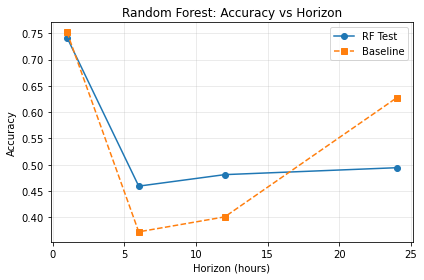

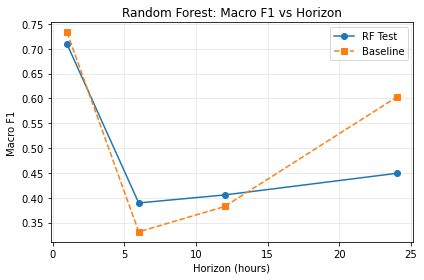

In [2]:
# ==================================================
# 6. 画 Accuracy / Macro F1 vs Horizon 折线图
# ==================================================
metrics_df = pd.DataFrame(rf_metrics).sort_values("horizon")
Hs = metrics_df["horizon"].values

# 图 1：Accuracy vs Horizon（Test + Baseline）
plt.figure(figsize=(6,4))
plt.plot(Hs, metrics_df["test_acc"], marker="o", label="RF Test")
plt.plot(Hs, metrics_df["baseline_acc"], marker="s", linestyle="--", label="Baseline")
plt.xlabel("Horizon (hours)")
plt.ylabel("Accuracy")
plt.title("Random Forest: Accuracy vs Horizon")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 图 2：Macro F1 vs Horizon（Test + Baseline）
plt.figure(figsize=(6,4))
plt.plot(Hs, metrics_df["test_f1"], marker="o", label="RF Test")
plt.plot(Hs, metrics_df["baseline_f1"], marker="s", linestyle="--", label="Baseline")
plt.xlabel("Horizon (hours)")
plt.ylabel("Macro F1")
plt.title("Random Forest: Macro F1 vs Horizon")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


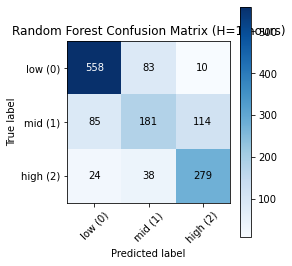

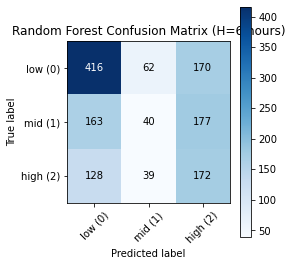

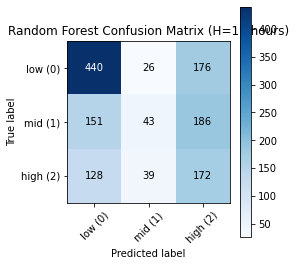

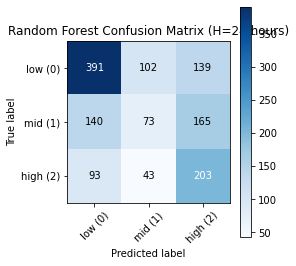

In [3]:
import numpy as np

class_names = ["low (0)", "mid (1)", "high (2)"]

for H in HORIZONS:
    cm = rf_conf_mats.get(H)
    if cm is None:
        continue

    plt.figure(figsize=(4,4))
    plt.imshow(cm, interpolation="nearest", cmap="Blues")
    plt.title(f"Random Forest Confusion Matrix (H={H} hours)")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # 在格子中写数字
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(
                j, i, str(cm[i, j]),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black"
            )

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()
